# Coherence Analyses

The notebook makes a comparison of the eigenvalue decay of coherence matrix in the case of the existence of microsiesmic events vs when there is no coherent event.

Coherence here is defined by Welch method for two signals, x and y as
$$Coherence(x,y) = \frac{|E[P_{xy}]|^2}{E[P_{xx}]E[P_{yy}]}$$

where $P_{xy}$ is the cross-spectral density of x and y, $P_{xx}$ is the power spectral density of x and $P_{yy}$ is the power spectral density of y.

As indicated in the second notebook, in our custom function, we represent the the computation of coherence matrix as a the squared absolute of the product of a matrix and its conjugate transpose, $U$. The columns of $U$ corresponding to a discrete frequency of the fourier transform in continuous time windows. Then the coherence matrix is computed as
$$C = |U^*U|^2$$

`normalised_windowed_spectra` computes $U$ and `welch_coherence_matrix` computes $C$ but does the normalization as the last step and does not explicitly compute $U$.

### Make imports and write functions

In [73]:
import sys

import h5py
from IPython.display import HTML, display
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from scipy.fft import ifft
import scipy.signal as ss
import scipy.linalg as sl
from sklearn.utils.extmath import randomized_svd
import time

sys.path.append('../')
import functions as f

### Parameters for data and tests

In [74]:
samples_per_sec=1000
fsize=15
nsensors=200
# start_ch = 1000
# nchannels = 3000

start_ch = 3100
nchannels = 2000
# nchannels = 5100

# start_ch = 10
# nchannels = 3000

# start_ch = 5500
# nchannels = 2500

# start_ch = 100
# nchannels = 5000

win_len = 2.5
overlap = 0

subwin_width = 4096 # number of samples in each subwindow
num_subwins = 10 # number of subwindows to average over
avgwin_width = num_subwins * subwin_width # number of samples in averaging window

colors = ['#800000', '#FFD700', '#663399', '#000000', '#008B8B']

# Background noise test

## Data

The data used in this notebook can be downloaded via the [AWS S3 Explorer for the Open Energy Data Initiative](https://data.openei.org/s3_viewer?bucket=nrel-pds-porotomo&prefix=DAS%2FH5%2FDASH%2F). The data is stored in the `nrel-pds-porotomo` bucket and the `DAS/H5/DASH/` prefix. There are separated by dates of recording and arranged in chronological order. The data is stored in the Hierarchical Data Format (HDF) and can be read using the `h5py` package. The file names end in the format `YYMMDDHHmmss.h5` where `YY` is the year, `MM` is the month, `DD` is the day, `HH` is the hour, `mm` is the minute, and `ss` is the second. 

In [75]:
file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160312000018.h5"
data_noise,_= f.loadBradyHShdf5(file,normalize='no')

file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160312000048.h5"
data_noise2,_= f.loadBradyHShdf5(file,normalize='no')

data_noise = np.append(data_noise,data_noise2,axis=1)

Compute $U$ and the coherence matrix, $C$.

In [76]:
norm_win_spectra, frequencies = f.normalised_windowed_spectra(data_noise[start_ch:nchannels+start_ch:int(nchannels/nsensors)], win_len, overlap, sample_interval=1/samples_per_sec)
welch_coherence_mat = np.matmul(norm_win_spectra, np.conjugate(norm_win_spectra.transpose(0,2,1)))
coherence = np.absolute(welch_coherence_mat)**2

# coherence, frequencies = welch_coherence(data_noise[start_ch:nchannels+start_ch:int(nchannels/nsensors)], win_len, overlap, sample_interval=1/samples_per_sec)

For each discrete frequency, compute the eigenvalues of the coherence matrix and compute a detection parameter as the ratio of the maximum eigenvalue to the sum of all eigenvalues. 

$$\text{Detection parameter} = \frac{\lambda_i}{\sum_{i=1}^{n}{\lambda_i}}$$

We do this with both the exact eigenvalues and the approximate eigenvalues computed using the proposed QR algorithm.

In [77]:
num_frames = coherence.shape[0]

noise_detection = np.empty(num_frames)
noise_detection_qr = np.empty(num_frames)
noise_detection_svd = np.empty(num_frames)

for d in range(num_frames):
    eigenvals = np.linalg.eigvalsh(coherence[d])
    # eigenvals, _ = np.linalg.eig(coherence[d])
    eigenvals = np.sort(eigenvals)[::-1]
    noise_detection[d] = eigenvals[0]/np.sum(eigenvals)

    Q,R = np.linalg.qr(norm_win_spectra[d])
    qr_approx = np.diag(R @ np.conjugate(R.transpose()))
    qr_approx = np.sort(qr_approx)[::-1]
    noise_detection_qr[d] = qr_approx[0]/np.sum(np.absolute(qr_approx))

    _, S, _ = np.linalg.svd(norm_win_spectra[d])
    svd_approx2 = S**2
    noise_detection_svd[d] = np.max(svd_approx2)/np.sum(svd_approx2)

C:\Users\issah\AppData\Local\Temp\ipykernel_24896\2633806625.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  noise_detection_qr[d] = qr_approx[0]/np.sum(np.absolute(qr_approx))


Plot the detection parameter as a function of the discrete frequency.

<>:12: SyntaxWarning: invalid escape sequence '\l'
<>:12: SyntaxWarning: invalid escape sequence '\l'
C:\Users\issah\AppData\Local\Temp\ipykernel_24896\2846259655.py:12: SyntaxWarning: invalid escape sequence '\l'
  plt.title("Proportion of $\lambda_1$ in sum of all eigenvalues",fontsize=fsize)


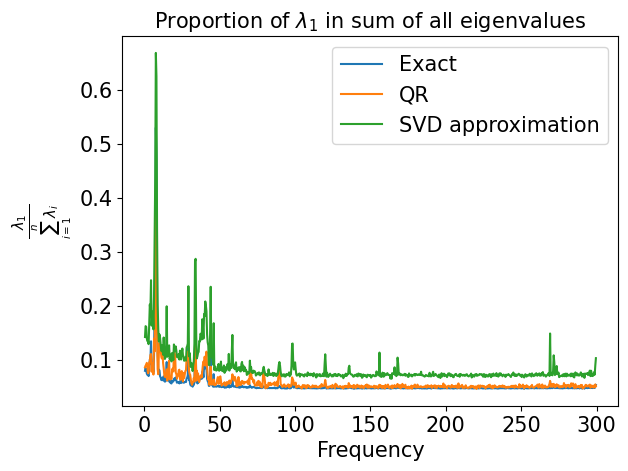

In [78]:
last_freq_index = 750

plt.plot(frequencies[1:last_freq_index], noise_detection[1:last_freq_index], label='Exact')
plt.plot(frequencies[1:last_freq_index], noise_detection_qr[1:last_freq_index], label='QR')
plt.plot(frequencies[1:last_freq_index], noise_detection_svd[1:last_freq_index], label='SVD approximation')


plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$",fontsize=fsize)
plt.xlabel("Frequency",fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.title("Proportion of $\lambda_1$ in sum of all eigenvalues",fontsize=fsize)
plt.legend(fontsize=fsize)

### Plot data

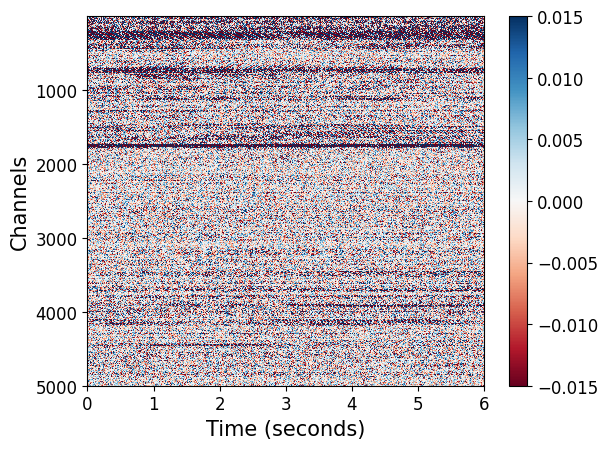

In [79]:
# pdata=np.append(data[:,24976:],data2[:,:10000],axis=1) 
# pdata=data_noise
# pdata = pdata[start_ch:nchannels+start_ch]
tick_size = 12
ch_start = 1
# v_min = -np.percentile(np.absolute(data_noise[start_ch:nchannels+start_ch]),95)
# v_max = np.percentile(np.absolute(data_noise[start_ch:nchannels+start_ch]),95)
v_min = -0.015
v_max = 0.015

# pdata = data[3000:8000, 47240:53256]

fig2 = plt.figure()
# img2 = plt.imshow(data_noise[start_ch:nchannels+start_ch], cmap="RdBu", 
img2 = plt.imshow(data_noise[3000:8000, 47240:53256], cmap="RdBu", 
           vmin=v_min, 
           vmax=v_max, aspect='auto', interpolation='none',
           extent=(0, 6, 5000, 1))
        #    extent=(0,len(data_noise[start_ch:nchannels+start_ch][0])/samples_per_sec, ch_start, ch_start + nchannels))
           #extent=(mdates.date2num(np.datetime64(props['GPSTimeStamp'])),mdates.date2num(np.datetime64(props['GPSTimeStamp'])+np.timedelta64(60,'s')), distances[0],distances[-1]))
plt.xlabel('Time (seconds)',fontsize=fsize)
plt.ylabel('Channels',fontsize=fsize)
# plt.title('Background noise',fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=tick_size)

# Small event test

In [80]:
file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314062648.h5"
data,_ = f.loadBradyHShdf5(file,normalize='no')

file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314062718.h5"
data2,_ = f.loadBradyHShdf5(file,normalize='no')

data = np.append(data,data2,axis=1)

In [81]:
t0 = time.time()
norm_win_spectra2, frequencies = f.normalised_windowed_spectra(data[start_ch:nchannels+start_ch:int(nchannels/nsensors)], win_len, overlap, sample_interval=1/samples_per_sec)
t1 = time.time()
common_time = t1-t0
welch_coherence_mat = np.matmul(norm_win_spectra2, np.conjugate(norm_win_spectra2.transpose(0,2,1)))
coherence2 = np.absolute(welch_coherence_mat)**2

# coherence2, frequencies = welch_coherence(data[start_ch:nchannels+start_ch:int(nchannels/nsensors)], win_len, overlap, sample_interval=1/samples_per_sec)

In [82]:
num_frames = coherence2.shape[0]

small_event_detection = np.empty(num_frames)
small_event_detection_qr = np.empty(num_frames)
small_event_detection_svd = np.empty(num_frames)
t0 = time.time()
welch_coherence_mat = np.matmul(norm_win_spectra2, np.conjugate(norm_win_spectra2.transpose(0,2,1)))
coherence2 = np.absolute(welch_coherence_mat)**2
for d in range(num_frames):
    # eigenvals, _ = np.linalg.eig(coherence2[d])
    eigenvals = np.linalg.eigvalsh(coherence2[d])
    # eigenvals = sl.eigvalsh(coherence2[d])
    eigenvals = np.sort(eigenvals)[::-1]
    small_event_detection[d] = np.max(eigenvals)/np.sum(eigenvals)
    # eig_ratios2[d] = eigenvals[0]/np.sum(eigenvals)
t1 = time.time()
eig_time = t1-t0 + common_time

t0 = time.time()
for d in range(num_frames):
    Q,R = np.linalg.qr(norm_win_spectra2[d])
    # qr_approx2 = np.sort(np.diag(np.absolute(R@(R.getH()))))[::-1]
    
    RRH = R@(np.matrix(R).H)
    # diag is of sqrt(RR^*)
    qr_approx2 = np.power(np.diag(RRH),1)
    small_event_detection_qr[d] = np.max(qr_approx2)/np.sum(qr_approx2)

    # qr_approx2 = np.diag(R @ np.conjugate(R.transpose()))
    # qr_approx2 = np.sort(qr_approx2)[::-1]
    # qr_approx2 = qr_approx2**1
    
    # eig_ratios_qr2[d] = qr_approx2[0]/np.sum(qr_approx2)
t1 = time.time()
qr_time = t1-t0 + common_time


t0 = time.time()
for d in range(num_frames):
    U, S, Vh = np.linalg.svd(norm_win_spectra2[d])
    svd_approx2 = S**2
    # svd_approx2 = np.sort(S)[::-1]**2
    small_event_detection_svd[d] = np.max(svd_approx2)/np.sum(svd_approx2)
t1 = time.time()
svd_time = t1-t0 + common_time


print("Eigenvalue time: ", eig_time)
print("QR time: ", qr_time)
print("SVD time: ", svd_time)

C:\Users\issah\AppData\Local\Temp\ipykernel_24896\1035496719.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  small_event_detection_qr[d] = np.max(qr_approx2)/np.sum(qr_approx2)


Eigenvalue time:  13.776067733764648
QR time:  2.799252986907959
SVD time:  5.160655736923218


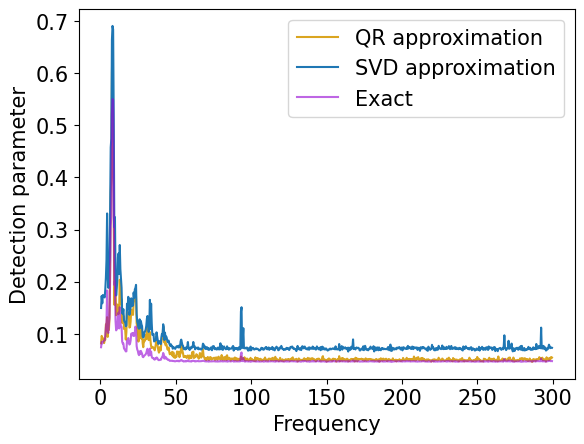

In [83]:
last_freq_index = 750

plt.plot(frequencies[1:last_freq_index], small_event_detection_qr[1:last_freq_index], color="goldenrod", label='QR approximation')
plt.plot(frequencies[1:last_freq_index], small_event_detection_svd[1:last_freq_index], label='SVD approximation')
plt.plot(frequencies[1:last_freq_index], small_event_detection[1:last_freq_index], color="darkviolet", alpha=0.6, label='Exact')
# plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$",fontsize=fsize)
plt.ylabel("Detection parameter",fontsize=fsize)
plt.xlabel("Frequency",fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
# plt.title("Proportion of $\lambda_1$ in sum of all eigenvalues",fontsize=fsize)
plt.legend(fontsize=fsize)

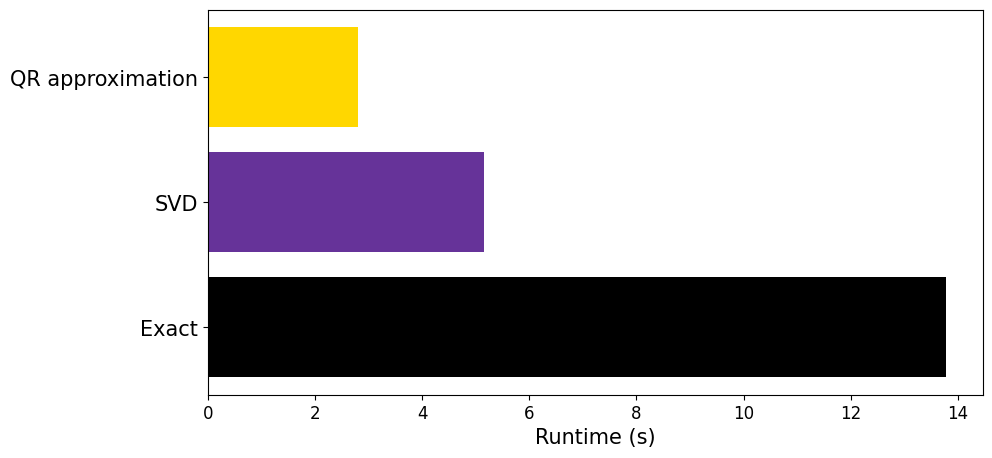

In [84]:
fig, ax = plt.subplots(figsize=(10, 5))

methods = ["Exact", "SVD", "QR approximation"]
# methods = [1, 1.2]
times = [eig_time, svd_time, qr_time]
bar_labels = ["Exact", "SVD", "QR approximation"]
# bar_colors = ['darkviolet', 'goldenrod']
# bar_colors = ['#800000', '#FFD700'] #'#FFA500']
bar_colors = [colors[3], colors[2], colors[1]]
# bar_colors = colors[2:4][::-1]

ax.barh(methods, times, label=bar_labels, color=bar_colors, height=0.8)

ax.set_xlabel('Runtime (s)', fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=fsize)
# ax.set_title('Runtime')
# ax.legend(fontsize=tick_size)

plt.show()

# Big event test

In [85]:
file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083848.h5"
data,_ = f.loadBradyHShdf5(file,normalize='no')

file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083918.h5"
data2,_= f.loadBradyHShdf5(file,normalize='no')

data = np.append(data,data2,axis=1)

In [86]:
t0 = time.time()
norm_win_spectra_big_event, frequencies = f.normalised_windowed_spectra(data[start_ch:nchannels+start_ch:int(nchannels/nsensors)], win_len, overlap, sample_interval=1/samples_per_sec)
t1 = time.time()
common_time = t1-t0
welch_coherence_mat = np.matmul(norm_win_spectra_big_event, np.conjugate(norm_win_spectra_big_event.transpose(0,2,1)))
coherence_big_event = np.absolute(welch_coherence_mat)**2

In [101]:
num_frames = coherence_big_event.shape[0]

big_event_detection = np.empty(num_frames)
big_event_detection_qr = np.empty(num_frames)
big_event_detection_svd = np.empty(num_frames)
t0 = time.time()
welch_coherence_mat = np.matmul(norm_win_spectra_big_event, np.conjugate(norm_win_spectra_big_event.transpose(0,2,1)))
coherence_big_event = np.absolute(welch_coherence_mat)**2
for d in range(num_frames):
    # eigenvals, _ = np.linalg.eig(coherence2[d])
    eigenvals = np.linalg.eigvalsh(coherence_big_event[d])
    # eigenvals = sl.eigvalsh(coherence2[d])
    eigenvals = np.sort(eigenvals)[::-1]
    big_event_detection[d] = np.max(eigenvals)/np.sum(eigenvals)
    # eig_ratios2[d] = eigenvals[0]/np.sum(eigenvals)
t1 = time.time()
eig_time = t1-t0 + common_time

t0 = time.time()
for d in range(num_frames):
    Q,R = np.linalg.qr(norm_win_spectra_big_event[d])
    # qr_approx2 = np.sort(np.diag(np.absolute(R@(R.getH()))))[::-1]
    
    RRH = R@(np.matrix(R).H)
    # diag is of sqrt(RR^*)
    qr_approx2 = np.power(np.diag(RRH),1)
    big_event_detection_qr[d] = np.max(qr_approx2)/np.sum(qr_approx2)

    # qr_approx2 = np.diag(R @ np.conjugate(R.transpose()))
    # qr_approx2 = np.sort(qr_approx2)[::-1]
    # qr_approx2 = qr_approx2**1
    
    # eig_ratios_qr2[d] = qr_approx2[0]/np.sum(qr_approx2)
t1 = time.time()
qr_time = t1-t0 + common_time


t0 = time.time()
for d in range(num_frames):
    U, S, Vh = np.linalg.svd(norm_win_spectra_big_event[d])
    svd_approx2 = S**2
    # svd_approx2 = np.sort(S)[::-1]**2
    big_event_detection_svd[d] = np.max(svd_approx2)/np.sum(svd_approx2)
t1 = time.time()
svd_time = t1-t0 + common_time


print("Eigenvalue time: ", eig_time)
print("QR time: ", qr_time)
print("SVD time: ", svd_time)

C:\Users\issah\AppData\Local\Temp\ipykernel_24896\1343759154.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  big_event_detection_qr[d] = np.max(qr_approx2)/np.sum(qr_approx2)


Eigenvalue time:  14.39723014831543
QR time:  1.882133960723877
SVD time:  5.734986066818237


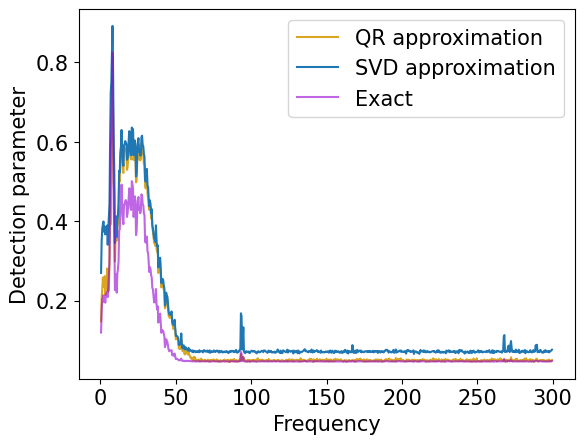

In [102]:
last_freq_index = 750

plt.plot(frequencies[1:last_freq_index], big_event_detection_qr[1:last_freq_index], color="goldenrod", label='QR approximation')
plt.plot(frequencies[1:last_freq_index], big_event_detection_svd[1:last_freq_index], label='SVD approximation')
plt.plot(frequencies[1:last_freq_index], big_event_detection[1:last_freq_index], color="darkviolet", alpha=0.6, label='Exact')
# plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$",fontsize=fsize)
plt.ylabel("Detection parameter",fontsize=fsize)
plt.xlabel("Frequency",fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
# plt.title("Proportion of $\lambda_1$ in sum of all eigenvalues",fontsize=fsize)
plt.legend(fontsize=fsize)

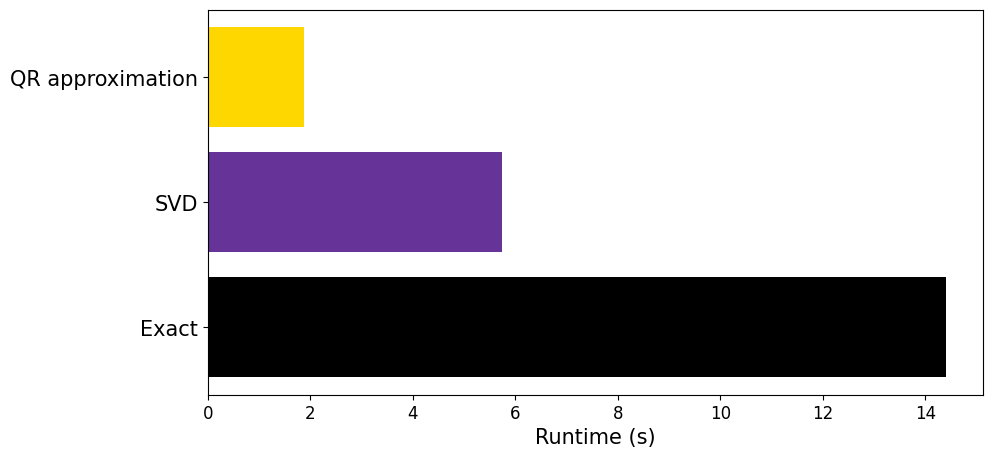

In [103]:
fig, ax = plt.subplots(figsize=(10, 5))

methods = ["Exact", "SVD", "QR approximation"]
# methods = [1, 1.2]
times = [eig_time, svd_time, qr_time]
bar_labels = ["Exact", "SVD", "QR approximation"]
# bar_colors = ['darkviolet', 'goldenrod']
# bar_colors = ['#800000', '#FFD700'] #'#FFA500']
bar_colors = [colors[3], colors[2], colors[1]]
# bar_colors = colors[2:4][::-1]

ax.barh(methods, times, label=bar_labels, color=bar_colors, height=0.8)

ax.set_xlabel('Runtime (s)', fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=fsize)
# ax.set_title('Runtime')
# ax.legend(fontsize=tick_size)

plt.show()

Plot to show relationship between between detection with coherence and its various approximations

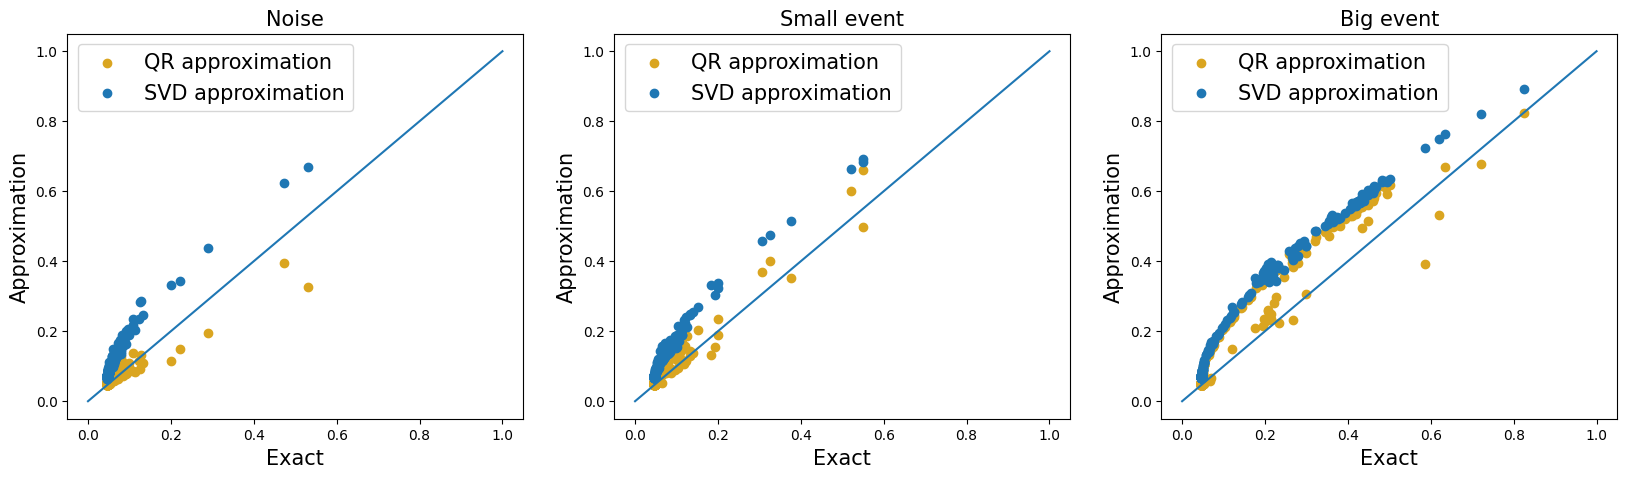

In [104]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.scatter(noise_detection[1:last_freq_index], noise_detection_qr[1:last_freq_index], color="goldenrod", label='QR approximation')
plt.scatter(noise_detection[1:last_freq_index], noise_detection_svd[1:last_freq_index], label='SVD approximation')
plt.plot(np.linspace(0,1,10),np.linspace(0,1,10))
plt.xlabel("Exact",fontsize=fsize)
plt.ylabel("Approximation",fontsize=fsize)
plt.title("Noise",fontsize=fsize)
plt.legend(fontsize=fsize)

plt.subplot(1,3,2)
plt.scatter(small_event_detection[1:last_freq_index], small_event_detection_qr[1:last_freq_index], color="goldenrod", label='QR approximation')
plt.scatter(small_event_detection[1:last_freq_index], small_event_detection_svd[1:last_freq_index], label='SVD approximation')
plt.plot(np.linspace(0,1,10),np.linspace(0,1,10))
plt.xlabel("Exact",fontsize=fsize)
plt.ylabel("Approximation",fontsize=fsize)
plt.title("Small event",fontsize=fsize)
plt.legend(fontsize=fsize)

plt.subplot(1,3,3)
plt.scatter(big_event_detection[1:last_freq_index], big_event_detection_qr[1:last_freq_index], color="goldenrod", label='QR approximation')
plt.scatter(big_event_detection[1:last_freq_index], big_event_detection_svd[1:last_freq_index], label='SVD approximation')
plt.plot(np.linspace(0,1,10),np.linspace(0,1,10))
plt.xlabel("Exact",fontsize=fsize)
plt.ylabel("Approximation",fontsize=fsize)
plt.title("Big event",fontsize=fsize)
plt.legend(fontsize=fsize)

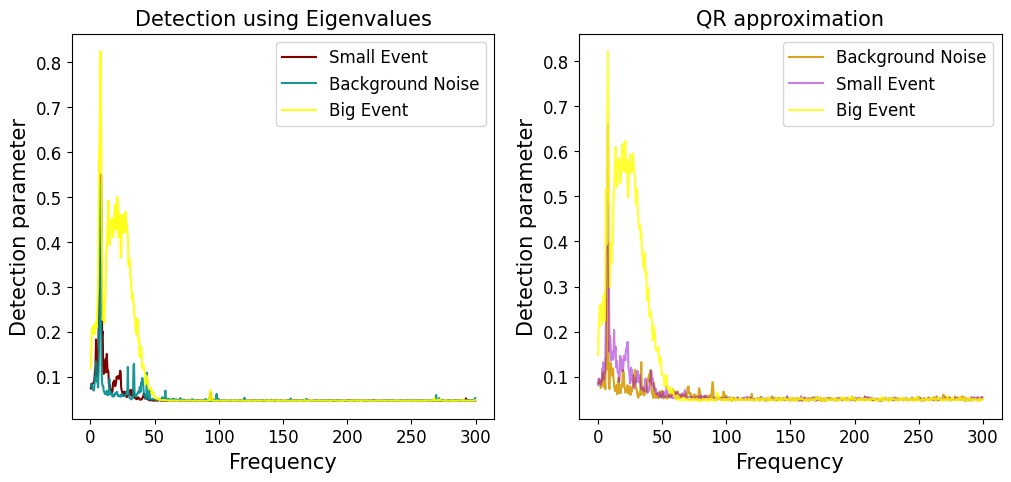

In [105]:
last_freq_index = 750
tick_size = 12

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(frequencies[1:last_freq_index], small_event_detection[1:last_freq_index], color=colors[0], label="Small Event")
plt.plot(frequencies[1:last_freq_index], noise_detection[1:last_freq_index], color=colors[-1], alpha=0.9 , label="Background Noise")
plt.plot(frequencies[1:last_freq_index], big_event_detection[1:last_freq_index], color="yellow", alpha=0.9 , label="Big Event")

# plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$",fontsize=fsize)
plt.ylabel("Detection parameter",fontsize=fsize)
plt.xlabel("Frequency",fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
# plt.title("Proportion of $\lambda_1$ in sum of all eigenvalues",fontsize=fsize)
plt.title("Detection using Eigenvalues",fontsize=fsize)
# plt.grid(minor=True)
plt.legend(fontsize=tick_size)

plt.subplot(1,2,2)
plt.plot(frequencies[1:last_freq_index], noise_detection_qr[1:last_freq_index], color="goldenrod", label="Background Noise")
plt.plot(frequencies[1:last_freq_index], small_event_detection_qr[1:last_freq_index], color="darkviolet", alpha=0.5 , label="Small Event")
plt.plot(frequencies[1:last_freq_index], big_event_detection_qr[1:last_freq_index], color="yellow", alpha=0.8 , label="Big Event")
# plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$",fontsize=fsize)
plt.ylabel("Detection parameter",fontsize=fsize)
plt.xlabel("Frequency",fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
# plt.title("Proportion of $\lambda_1$ in sum of all eigenvalues",fontsize=fsize)
plt.title("QR approximation",fontsize=fsize)
# plt.grid(minor=True)
plt.legend(fontsize=tick_size)

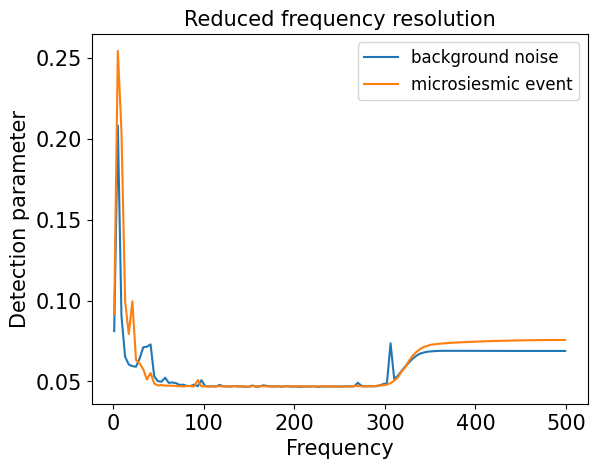

In [92]:

avg_eigs = np.mean(noise_detection[1:].reshape((125,10)), axis=1)
avg_eigs2 = np.mean(small_event_detection[1:].reshape((125,10)), axis=1)
avg_freq = np.linspace(1,499,125)

plt.plot(avg_freq, avg_eigs, label="background noise")
plt.plot(avg_freq, avg_eigs2, label="microsiesmic event")

# plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$",fontsize=fsize)
plt.ylabel("Detection parameter",fontsize=fsize)
plt.xlabel("Frequency",fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
# plt.title("Proportion of $\lambda_1$ in sum of all eigenvalues",fontsize=fsize)
plt.title("Reduced frequency resolution",fontsize=fsize)
plt.legend(fontsize=tick_size)


### Plot data

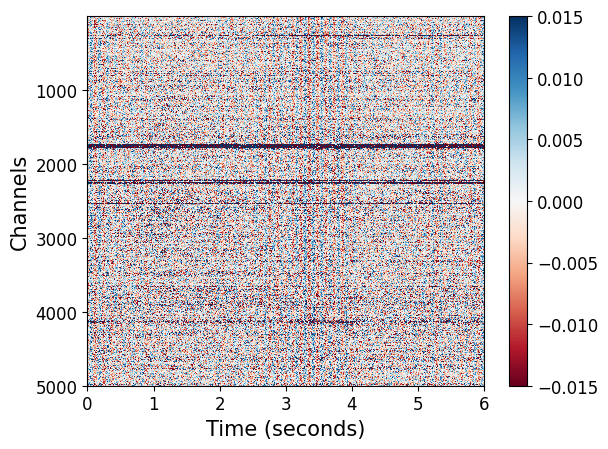

In [93]:
fsize=15
tick_size = 12
ch_start = 1
# pdata = data[start_ch:nchannels+start_ch, 47000:54000]
# pdata = data[start_ch+int(nchannels/2):nchannels*2+start_ch, 47000:53000]
pdata = data[3000:8000, 47240:53256]
# templateSamples=[17240, 23256]

# v_min = -np.percentile(np.absolute(pdata),95)
# v_max = np.percentile(np.absolute(pdata),95)
v_min = -0.015
v_max = 0.015

fig2 = plt.figure()
img2 = plt.imshow(pdata, cmap="RdBu", 
           vmin=v_min, 
           vmax=v_max, aspect='auto', interpolation='none',
           extent=(0,6, 5000, 1))
         #   extent=(0,len(pdata[0])/samples_per_sec, ch_start, ch_start + nchannels))
           #extent=(mdates.date2num(np.datetime64(props['GPSTimeStamp'])),mdates.date2num(np.datetime64(props['GPSTimeStamp'])+np.timedelta64(60,'s')), distances[0],distances[-1]))
plt.xlabel('Time (seconds)',fontsize=fsize)
plt.ylabel('Channels',fontsize=fsize)
# plt.title('Signal',fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=tick_size)

Text(0.5, 1.0, 'QR Approximation of Eigenvalues')

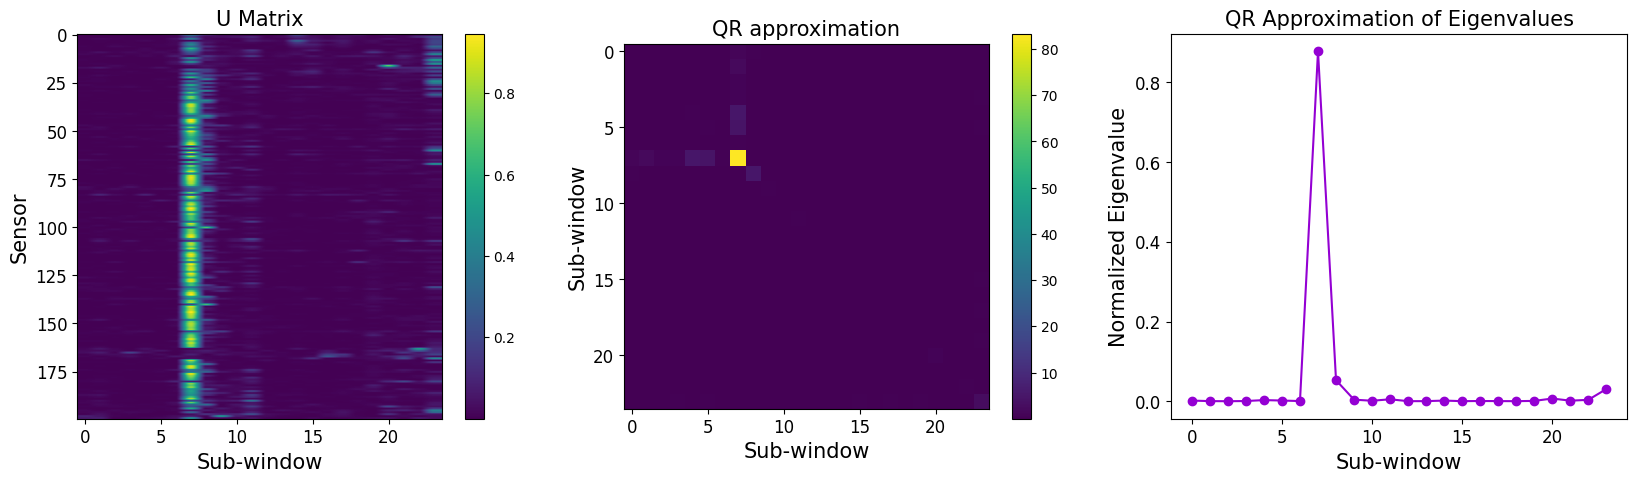

In [94]:
RandA = norm_win_spectra_big_event[39,:,:]**2
Q1,R1 = np.linalg.qr(RandA)

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.imshow(np.abs(RandA), aspect='auto')
plt.ylabel('Sensor', fontsize=fsize)
plt.xlabel('Sub-window', fontsize=fsize)
# plt.title('QR approximation', fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('U Matrix', fontsize=fsize)
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(np.abs(R1@np.conjugate(R1).T))
plt.ylabel('Sub-window', fontsize=fsize)
plt.xlabel('Sub-window', fontsize=fsize)
plt.title('QR approximation', fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.colorbar()

plt.subplot(1,3,3)
qr_ = np.diag(np.absolute(R1@R1.transpose()))
plt.plot(qr_/np.sum(qr_), '-o', color="darkviolet")
plt.ylabel('Normalized Eigenvalue', fontsize=fsize)
plt.xlabel('Sub-window', fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('QR Approximation of Eigenvalues', fontsize=fsize)
# plt.title('QR Approximation of Eigenvalues', fontsize=15)
# print(np.max(qr_)/np.sum(np.absolute(qr_)))


Text(0.5, 1.0, 'Diagonal of R')

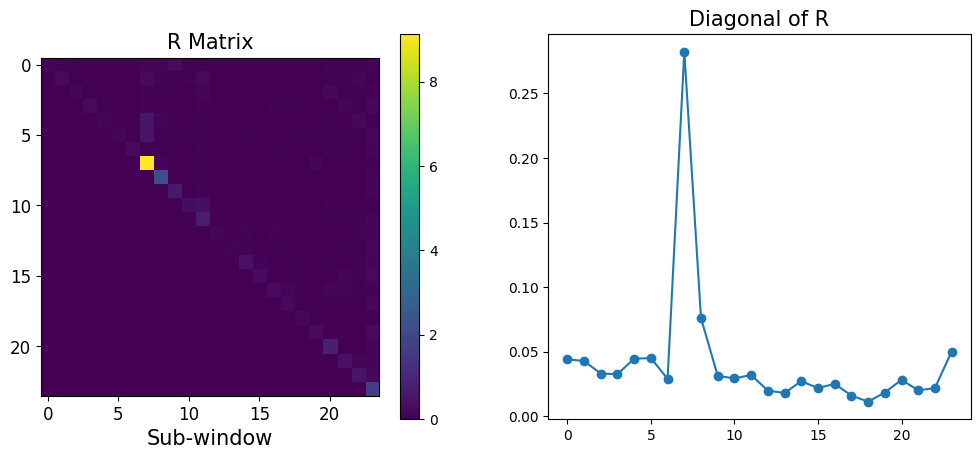

In [95]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(np.abs(R1))
plt.title('R Matrix', fontsize=fsize)
# plt.ylabel('Sub-window', fontsize=fsize)
plt.xlabel('Sub-window', fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.colorbar()
# plt.subplot(1,2,2)
# plt.plot(frequencies)

plt.subplot(1,2,2)
# plt.plot(np.abs(R1)[9], '-o')
# plt.plot(np.abs(R1@R1.T)[9], '-o')
# R1[-1]
appr = np.sum(np.abs(R1), axis=1)
plt.plot(appr/np.sum(appr), '-o')
plt.title('Diagonal of R', fontsize=fsize)


This was an intended comparison between coherence and STA/LTA. It should be moved to a separate notebook.

In [96]:
def stalta_freq(data, len_lt, len_st):
    # Does stalta on data with len_lt as the length of the longtime and len_st
    # as the length of the short time
    if data.ndim == 1:
        longtime_avg = ss.correlate(np.absolute(data), np.ones(len_lt), mode = "valid")
        shorttime_avg = ss.correlate(np.absolute(data[(len_lt - len_st):]), np.ones(len_st), mode = "valid")
        stalta = (shorttime_avg * len_lt)/(longtime_avg * len_st)
    elif data.ndim == 2:
        nch, nsamples = data.shape
        stalta = np.empty((nch, nsamples - len_lt + 1), dtype=np.float64)
        longtime_stencil = np.ones(int(len_lt))
        shorttime_stencil = np.ones(int(len_st))
        for a in range(nch):
            longtime_avg = ss.correlate(np.absolute(data[a]), longtime_stencil, mode = "valid")
            shorttime_avg = ss.correlate(np.absolute(data[a, int(len_lt - len_st):]), shorttime_stencil, mode = "valid")
            stalta[a] = (shorttime_avg * len_lt)/(longtime_avg * len_st)

    return stalta

stalta_data = stalta_freq(data[start_ch:nchannels+start_ch:int(nchannels/nsensors)], 2000, 300)

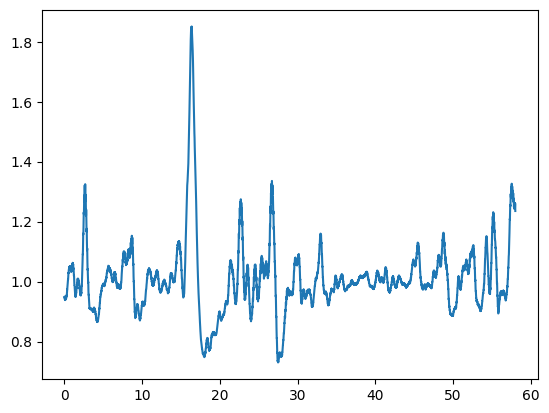

In [97]:
xax = np.array(range(stalta_data.shape[1]))/1000
plt.plot(xax, np.mean(stalta_data, axis=0))